In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **ENCODING**

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict
from scipy import fft
from scipy.ndimage import zoom
import tempfile
from google.colab.patches import cv2_imshow
import os

# User Input

In [ ]:
image_filename = input("Enter image path: ")
block_size = int(input("Enter block size: "))
number_of_coefficients = int(input("Enter number of coefficients (< block_size * block_size): "))
while not number_of_coefficients <= block_size * block_size :
  number_of_coefficients = int(input("Enter number of coefficients (< block_size * block_size): "))
img_color = int(input("Enter 0 for color image and 1 for grayscale image: "))

Enter image path: /content/drive/MyDrive/DIP/dataset/assignment 4/kodim09.png
Enter block size: 16
Enter number of coefficients (< block_size * block_size): 1
Enter 0 for color image and 1 for grayscale image: 1


# Display Input Image

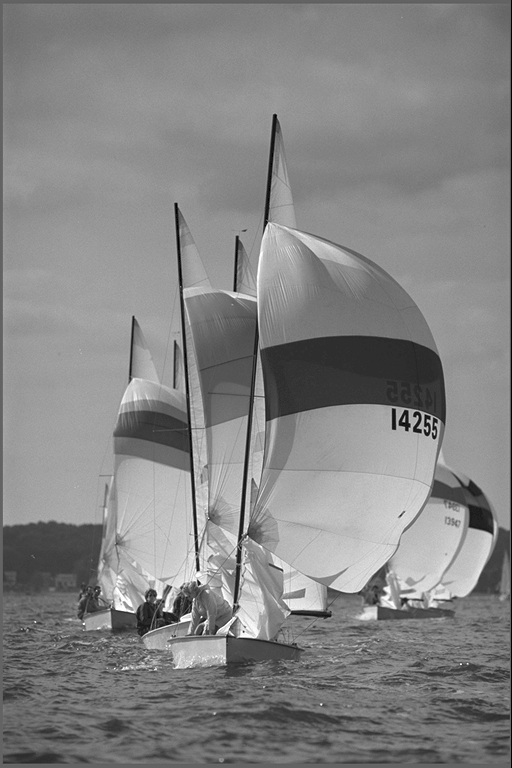

In [ ]:
if img_color == 1:
  input_image_jpg = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
  cv2_imshow(input_image_jpg)
else:
  input_image_jpg = cv2.imread(image_filename, cv2.IMREAD_COLOR)
  cv2_imshow(input_image_jpg)
  input_image_jpg = cv2.cvtColor(input_image_jpg, cv2.COLOR_BGR2YCrCb)
  cv2_imshow(input_image_jpg)

In [ ]:
input_image_jpg.shape


(768, 512)

In [ ]:
# input_image_jpg[-1]

# Divide image into blocks

In [ ]:
def divide_image_into_blocks(image, new_height, new_width, block_size, img_color):
    blocks = []
    for i in range(0, new_height, block_size):
        for j in range(0, new_width, block_size):
            if img_color == 1:
                block = image[i:i+block_size, j:j+block_size]
            else:
                block = image[i:i+block_size, j:j+block_size, :3]
            blocks.append(block)
    return np.array(blocks).astype(int)

In [ ]:
created_blocks = divide_image_into_blocks(input_image_jpg, input_image_jpg.shape[0], input_image_jpg.shape[1], block_size, img_color)

if img_color == 0 : #YcbCr
  Y_channel_data = created_blocks[:, :, :, 0]
  Cb_channel_data = created_blocks[:, :, :, 1]
  Cr_channel_data = created_blocks[:, :, :, 2]

In [ ]:
created_blocks[2]

array([[ 99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99],
       [ 99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99],
       [ 96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,
         96,  96,  96],
       [110, 107, 109, 107, 110, 107, 110, 107, 107, 109, 110, 109, 109,
        110, 105, 107],
       [124, 128, 126, 125, 127, 124, 124, 126, 126, 125, 129, 127, 126,
        127, 126, 129],
       [124, 124, 122, 118, 119, 124, 122, 124, 125, 125, 125, 122, 122,
        123, 124, 123],
       [124, 124, 120, 124, 122, 122, 125, 126, 126, 122, 120, 126, 123,
        122, 123, 122],
       [118, 120, 122, 125, 123, 126, 124, 125, 124, 125, 126, 125, 125,
        123, 122, 126],
       [122, 120, 124, 120, 120, 125, 124, 127, 123, 123, 123, 125, 122,
        125, 126, 123],
       [120, 120, 125, 125, 122, 125, 122, 125, 125, 120, 125, 127, 126,
        126, 125, 123],
       [125, 120, 122, 123, 12

In [ ]:
# Y_channel_data[-1]

# Count Number of blocks

In [ ]:
print(len(created_blocks))

1536


# Performing Discrete Cosine Transform

In [ ]:
if img_color == 1 :  #Grayscale Image
    dct_blocks = []
    for block in created_blocks:
        block -= 128
        dct = fft.dctn(block, type=2, norm='ortho')
        dct_blocks.append(dct)

    dct_blocks = np.array(dct_blocks).astype(int)

else :
    dct_blocks_y, dct_blocks_cb, dct_blocks_cr = [], [], []
    for l, block in enumerate(Y_channel_data):
        block -= 128
        dct = fft.dctn(block, type=2, norm='ortho')
        dct_blocks_y.append(dct)

    dct_blocks_y = np.array(dct_blocks_y).astype(int)


    for l, block in enumerate(Cb_channel_data):
        block -= 128
        dct = fft.dctn(block, type=2, norm='ortho')
        dct_blocks_cb.append(dct)

    dct_blocks_cb = np.array(dct_blocks_cb).astype(int)


    for l, block in enumerate(Cr_channel_data):
        block -= 128
        dct = fft.dctn(block, type=2, norm='ortho')
        dct_blocks_cr.append(dct)

    dct_blocks_cr = np.array(dct_blocks_cr).astype(int)


In [ ]:
# type(dct_blocks_y)
# dct_blocks[-1]

# Define and Resize Quantization Matrix

In [ ]:
quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                  [12, 12, 14, 19, 26, 58, 60, 55],
                                  [14, 13, 16, 24, 40, 57, 69, 56],
                                  [14, 17, 22, 29, 51, 87, 80, 62],
                                  [18, 22, 37, 56, 68, 109, 103, 77],
                                  [24, 35, 55, 64, 81, 104, 113, 92],
                                  [49, 64, 78, 87, 103, 121, 120, 101],
                                  [72, 92, 95, 98, 112, 100, 103, 99]])

quantization_matrix_CbCr = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                                      [18, 21, 26, 66, 99, 99, 99, 99],
                                      [24, 26, 56, 99, 99, 99, 99, 99],
                                      [47, 66, 99, 99, 99, 99, 99, 99],
                                      [99, 99, 99, 99, 99, 99, 99, 99],
                                      [99, 99, 99, 99, 99, 99, 99, 99],
                                      [99, 99, 99, 99, 99, 99, 99, 99],
                                      [99, 99, 99, 99, 99, 99, 99, 99]])

In [ ]:
def resize_matrix(matrix, new_height, new_width):
    old_height, old_width = matrix.shape

    scale_height = new_height / old_height
    scale_width = new_width / old_width

    resized_matrix = zoom(matrix, (scale_height, scale_width), order=2)

    resized_matrix = np.round(resized_matrix).astype(np.int8)

    return resized_matrix.astype(int)

In [ ]:
resized_matrix = resize_matrix(quantization_matrix, block_size, block_size)
resized_matrix_cbcr = resize_matrix(quantization_matrix_CbCr, block_size, block_size)

In [ ]:
resized_matrix

array([[ 16,  14,  11,  10,  10,  11,  15,  18,  21,  27,  35,  42,  47,
         52,  58,  61],
       [ 14,  13,  12,  11,  11,  13,  16,  18,  20,  28,  40,  49,  52,
         54,  57,  59],
       [ 12,  12,  12,  12,  13,  15,  18,  19,  21,  31,  48,  59,  61,
         59,  57,  55],
       [ 12,  12,  12,  13,  14,  17,  20,  23,  26,  35,  50,  61,  65,
         63,  58,  54],
       [ 14,  13,  13,  13,  15,  18,  21,  27,  34,  42,  50,  58,  66,
         68,  61,  56],
       [ 14,  14,  14,  15,  17,  19,  22,  29,  38,  48,  58,  66,  72,
         71,  63,  57],
       [ 14,  14,  16,  18,  20,  21,  24,  30,  41,  55,  72,  82,  82,
         76,  66,  60],
       [ 15,  16,  18,  21,  24,  28,  33,  39,  47,  63,  85,  97,  94,
         84,  72,  65],
       [ 17,  17,  20,  24,  30,  38,  47,  53,  57,  71,  95, 108, 106,
         96,  81,  73],
       [ 19,  20,  23,  29,  38,  47,  56,  62,  65,  77,  98, 112, 113,
        104,  89,  80],
       [ 20,  22,  28,  37,  4

In [ ]:
resized_matrix_cbcr

array([[ 17,  17,  18,  19,  23,  29,  39,  60,  89, 103, 101,  98,  98,
         99,  99,  99],
       [ 17,  18,  19,  20,  22,  30,  44,  65,  90, 103, 101,  99,  99,
         99,  99,  99],
       [ 18,  19,  21,  21,  23,  35,  55,  75,  93, 101, 100,  99,  99,
         99,  99,  99],
       [ 19,  20,  21,  23,  31,  48,  72,  89,  97, 100, 100,  99,  99,
         99,  99,  99],
       [ 23,  22,  23,  31,  45,  66,  90, 101, 100,  99,  99,  99,  99,
         99,  99,  99],
       [ 29,  30,  35,  48,  66,  84,  99, 104, 101,  98,  99,  99,  99,
         99,  99,  99],
       [ 39,  44,  55,  72,  90,  99, 100, 100,  99,  99,  99,  99,  99,
         99,  99,  99],
       [ 60,  65,  75,  89, 101, 104, 100,  98,  99,  99,  99,  99,  99,
         99,  99,  99],
       [ 89,  90,  93,  97, 100, 101,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99],
       [103, 103, 101, 100,  99,  98,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99],
       [101, 101, 100, 100,  9

# Performing Quantization

In [ ]:
if img_color == 1 : #Grayscale
  quantized_blocks = np.zeros_like(dct_blocks)

  for i in range(len(dct_blocks)):
      quantized_blocks[i] = np.round(dct_blocks[i] / resized_matrix)

  quantized_blocks = quantized_blocks.astype(int)


else :

  Y_quantized_blocks = np.zeros_like(dct_blocks_y)
  for i in range(len(dct_blocks_y)):
      Y_quantized_blocks[i] = np.round(dct_blocks_y[i] / resized_matrix)

  Y_quantized_blocks = Y_quantized_blocks.astype(int)

  Cb_quantized_blocks = np.zeros_like(dct_blocks_cb)

  for i in range(len(dct_blocks_cb)):
      Cb_quantized_blocks[i] = np.round(dct_blocks_cb[i] / resized_matrix_cbcr)

  Cb_quantized_blocks = Cb_quantized_blocks.astype(int)

  Cr_quantized_blocks = np.zeros_like(dct_blocks_cr)

  for i in range(len(dct_blocks_cr)):
      Cr_quantized_blocks[i] = np.round(dct_blocks_cr[i] / resized_matrix_cbcr)

  Cr_quantized_blocks = Cr_quantized_blocks.astype(int)




In [ ]:
# quantized_blocks[-1]

# Performing Zigzag traversal

In [ ]:
def zigzag(quant_blocks, numCoeff):
    output = np.zeros((quant_blocks.shape[0], numCoeff))
    for idx, matrix in enumerate(quant_blocks):
        h = 0
        v = 0
        v_min = 0
        h_min = 0
        v_max = matrix.shape[0]
        h_max = matrix.shape[1]
        i = 0

        while (v < v_max) and (h < h_max):
            if ((h + v) % 2) == 0:
                if v == v_min:
                    output[idx, i] = matrix[v, h]
                    if h == h_max - 1:
                        v += 1
                    else:
                        h += 1
                    i += 1
                elif (h == h_max - 1) and (v < v_max):
                    output[idx, i] = matrix[v, h]
                    v += 1
                    i += 1
                elif (v > v_min) and (h < h_max - 1):
                    output[idx, i] = matrix[v, h]
                    v -= 1
                    h += 1
                    i += 1
            else:
                if h == h_min:
                    output[idx, i] = matrix[v, h]
                    if v == v_max - 1:
                        h += 1
                    else:
                        v += 1
                    i += 1
                elif (v == v_max - 1) and (h < h_max):
                    output[idx, i] = matrix[v, h]
                    h += 1
                    i += 1
                elif (v < v_max - 1) and (h > h_min):
                    output[idx, i] = matrix[v, h]
                    v += 1
                    h -= 1
                    i += 1

            if i >= numCoeff:
                break

        while i < numCoeff:
            output[idx, i] = output[idx, i - 1]
            i += 1

    return output.astype(int)


In [ ]:
if img_color == 1 :  #Grayscale
  zigzag_arr_list_gray = zigzag(quantized_blocks, number_of_coefficients)

else :
  zigzag_arr_list_y = zigzag(Y_quantized_blocks, number_of_coefficients)
  zigzag_arr_list_cb = zigzag(Cb_quantized_blocks, number_of_coefficients)
  zigzag_arr_list_cr = zigzag(Cr_quantized_blocks, number_of_coefficients)

In [ ]:
# zigzag_arr_list_gray[-1]

# Performing Huffman Encoding

In [ ]:
def huffman_encoding(zigzag_data):
    freqs = defaultdict(int)
    for val in zigzag_data:
        freqs[tuple(val)] += 1

    heap = [[freq, [val, ""]] for val, freq in freqs.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = "0" + pair[1]
        for pair in hi[1:]:
            pair[1] = "1" + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    huffman_dict = dict(heapq.heappop(heap)[1:])

    huffman_encoding = "".join(huffman_dict[tuple(val)] for val in zigzag_data)

    return huffman_encoding, huffman_dict

In [ ]:
if img_color == 1:   # Grayscale Image
    encoded_data_gray, dict_gray = huffman_encoding(zigzag_arr_list_gray)

else:
    encoded_data_y, dict_y = huffman_encoding(zigzag_arr_list_y)
    encoded_data_cr, dict_cr = huffman_encoding(zigzag_arr_list_cb)
    encoded_data_cb, dict_cb = huffman_encoding(zigzag_arr_list_cr)

# Write encoded data into text file

In [ ]:
text_filename = image_filename + '_jpgcode.txt'
if os.path.exists(text_filename):
    # Delete contents of existing file
    with open(text_filename, "w") as f:
        f.write("")

if img_color == 1: #Grayscale
    with open(text_filename, "w") as f:
        f.write(encoded_data_gray + "\n")
        f.write(str(dict_gray))

else:
    with open(text_filename, "w") as f:
        f.write(encoded_data_y + "\n")
        f.write(str(dict_y) + "\n")
        f.write(encoded_data_cr + "\n")
        f.write(str(dict_cr) + "\n")
        f.write(encoded_data_cb + "\n")
        f.write(str(dict_cb) + "\n")


print("Done!")

Done!


# **DECODING**

# Reading encoded data from the text file

In [ ]:
if img_color == 1:
    with open(text_filename, "r") as f:
        text_data_gray = f.readline().strip()
        text_dict_gray = eval(f.readline())
else:
    with open(text_filename, "r") as f:
        text_data_y = f.readline().strip()
        text_dict_y = eval(f.readline())
        text_data_cr = f.readline().strip()
        text_dict_cr = eval(f.readline())
        text_data_cb = f.readline().strip()
        text_dict_cb = eval(f.readline())

print("Done")

Done


# Huffman Decoding

In [ ]:
def huffman_decoding(encoded_data, codeword_dict):
    reverse_dict = {v: k for k, v in codeword_dict.items()}
    decoded_data = []
    current_code = ""
    for bit in encoded_data:
        current_code += bit
        decoded_symbol = reverse_dict.get(current_code)
        if decoded_symbol is not None:
            decoded_data.append(decoded_symbol)
            current_code = ""
    zigzag_data = np.array(decoded_data)
    return zigzag_data

In [ ]:
if img_color == 1: #Grayscale
    decoded_data_gray = huffman_decoding(text_data_gray, text_dict_gray)
else:
    decoded_data_y = huffman_decoding(text_data_y, text_dict_y)
    decoded_data_cr = huffman_decoding(text_data_cr, text_dict_cr)
    decoded_data_cb = huffman_decoding(text_data_cb, text_dict_cb)

In [ ]:
# decoded_data_gray[-1]

# Inverse Zigzag

In [ ]:
def reconstruct_from_zigzag(zigzag, block_size):

    v_max = block_size
    h_max = block_size
    matrix = np.zeros((v_max, h_max))

    h = 0
    v = 0
    v_min = 0
    h_min = 0
    i = 0

    while (v < v_max) and (h < h_max):
        if i >= len(zigzag):
          break
        if ((h + v) % 2) == 0:
            if v == v_min:
                matrix[v, h] = zigzag[i]
                if h == h_max - 1:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):
                matrix[v, h] = zigzag[i]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):
                matrix[v, h] = zigzag[i]
                v = v - 1
                h = h + 1
                i = i + 1
        else:
            if h == h_min:
                matrix[v, h] = zigzag[i]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif (v == v_max - 1) and (h <= h_max - 1):
                matrix[v, h] = zigzag[i]
                h = h + 1
                i = i + 1
            elif (v < v_max - 1) and (h > h_min):
                matrix[v, h] = zigzag[i]
                v = v + 1
                h = h - 1
                i = i + 1


    return matrix


In [ ]:
if img_color == 1: #Grayscale
    pre_dequantized_gray = []
    for block in decoded_data_gray:
      m1 = reconstruct_from_zigzag(block, block_size)
      pre_dequantized_gray.append(m1)

    pre_dequantized_gray = np.array(pre_dequantized_gray).astype(int)

else:
    pre_dequantized_y, pre_dequantized_cb, pre_dequantized_cr = [], [], []

    for block in decoded_data_y:
      m1 = reconstruct_from_zigzag(block, block_size)
      pre_dequantized_y.append(m1)

    for block in decoded_data_cb:
      m1 = reconstruct_from_zigzag(block, block_size)
      pre_dequantized_cb.append(m1)

    for block in decoded_data_cr:
      m1 = reconstruct_from_zigzag(block, block_size)
      pre_dequantized_cr.append(m1)

    pre_dequantized_y = np.array(pre_dequantized_y).astype(int)
    pre_dequantized_cb = np.array(pre_dequantized_cb).astype(int)
    pre_dequantized_cr = np.array(pre_dequantized_cr).astype(int)

In [ ]:
# pre_dequantized_gray[-1]

In [ ]:
# pre_dequantized_gray[1] * resized_matrix

# Dequantization

In [ ]:
if img_color == 1 : #Grayscale
  de_quantized_blocks_gray = []

  for i, block in enumerate(pre_dequantized_gray):
      de_quantized_block_gray = np.round(block * resized_matrix)
      de_quantized_blocks_gray.append(de_quantized_block_gray)
      # if(i == 1):
      #   print(f"Block {i+1} - Quantized Matrix:")
      #   print(de_quantized_block_gray)
      #   print("------------------------------")
  # print(quantized_blocks)
else :

  de_quantized_blocks_color_y = []
  de_quantized_blocks_color_cb = []
  de_quantized_blocks_color_cr = []
  for block1, block2, block3 in zip(pre_dequantized_y,pre_dequantized_cb, pre_dequantized_cr) :

    # Perform quantization on Y, Cb, and Cr channels
    Y_de_quantized = np.round(block1 * resized_matrix)
    Cb_de_quantized = np.round(block2 * resized_matrix_cbcr)
    Cr_de_quantized = np.round(block3 * resized_matrix_cbcr)
    # image_ycbcr_de_quantized = cv2.merge((Y_de_quantized, Cb_de_quantized, Cr_de_quantized))

    de_quantized_blocks_color_y.append(Y_de_quantized)
    de_quantized_blocks_color_cb.append(Cb_de_quantized)
    de_quantized_blocks_color_cr.append(Cr_de_quantized)

    # if(j == 0):
    #   print(block.shape)
    #   print(f"Block {j+1} - Quantized Matrix:")
    #   print(image_ycbcr_de_quantized)
    #   print("------------------------------")



In [ ]:
# de_quantized_blocks_gray[-1]

# Performing Inverse DCT

In [ ]:
def perform_idct(blocks):
  idct_blocks = np.array([fft.idctn(block, norm='ortho') for block in blocks])

  return idct_blocks.astype(int)

In [ ]:
if img_color == 1:
    inverse_dct_blocks_gray = perform_idct(de_quantized_blocks_gray)
else:
    inverse_dct_blocks_y = perform_idct(de_quantized_blocks_color_y)
    inverse_dct_blocks_cb = perform_idct(de_quantized_blocks_color_cb)
    inverse_dct_blocks_cr = perform_idct(de_quantized_blocks_color_cr)

In [ ]:
# inverse_dct_blocks_gray[-1]

# Merge the blocks

In [ ]:
def merge_blocks(blocks, rows, cols, blockSize):
    img = np.zeros((rows, cols))
    block_idx = 0
    for i in range(0, rows, blockSize):
        for j in range(0, cols, blockSize):
            if block_idx < len(blocks):
                img[i:i+blockSize, j:j+blockSize] = blocks[block_idx]
                block_idx += 1
    return img.astype(int)


In [ ]:
if img_color == 1:
    inverse_dct_blocks_gray += 128
    image_reconstructed = merge_blocks(inverse_dct_blocks_gray, input_image_jpg.shape[0], input_image_jpg.shape[1], block_size)

else:
    inverse_dct_blocks_y += 128
    inverse_dct_blocks_cb += 128
    inverse_dct_blocks_cr += 128

    reconstructed_y = merge_blocks(inverse_dct_blocks_y, input_image_jpg.shape[0], input_image_jpg.shape[1], block_size)
    reconstructed_cb = merge_blocks(inverse_dct_blocks_cb, input_image_jpg.shape[0], input_image_jpg.shape[1], block_size)
    reconstructed_cr = merge_blocks(inverse_dct_blocks_cr, input_image_jpg.shape[0], input_image_jpg.shape[1], block_size)

In [ ]:
if img_color == 1:
    image_reconstructed = np.array(image_reconstructed).astype(np.uint8)
else:
    image_reconstructed = []

    for y, cr, cb in zip(reconstructed_y, reconstructed_cb, reconstructed_cr):
        block = [[y[i], cb[i], cr[i]] for i in range(len(y))]

        image_reconstructed.append(block)
    image_reconstructed = np.array(image_reconstructed).astype(np.uint8)

In [ ]:
image_reconstructed.shape

(512, 768)

In [ ]:
# reconstructed_image_color_ycbcr[-1]

# Display reconstructed image

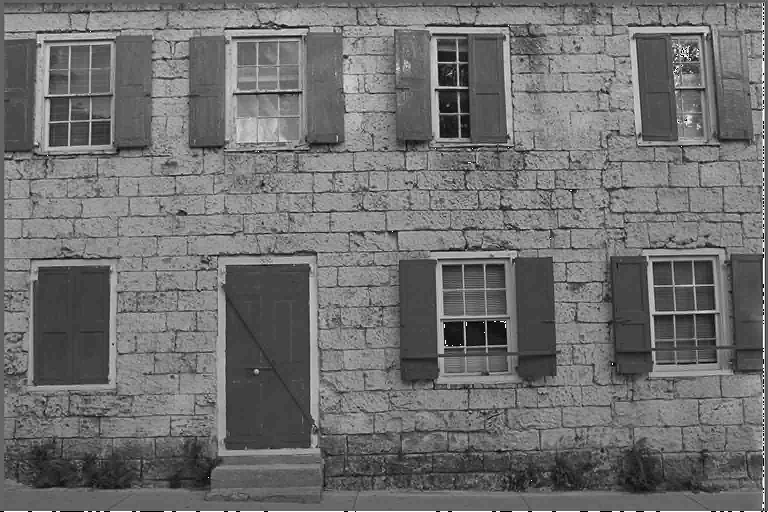

In [ ]:
if img_color == 0 :
  # reconstructed_image_color = cv2.cvtColor(reconstructed_image_color, cv2.COLOR_BGR2GRAY)
  cv2_imshow(image_reconstructed)
  image_reconstructed = cv2.cvtColor(image_reconstructed, cv2.COLOR_YCrCb2BGR)
  cv2_imshow(image_reconstructed)


  input_image_jpg = cv2.cvtColor(input_image_jpg, cv2.COLOR_YCrCb2BGR)

else :
  cv2_imshow(image_reconstructed)

# Calculate RMSE

In [ ]:
diff = np.subtract(input_image_jpg, image_reconstructed)

# Calculate the squared difference
squared_diff = np.square(diff)

# Calculate the mean of squared differences
mean_squared_diff = np.mean(squared_diff)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_diff)

print('RMSE between Original Image and Reconstructed Image: {:.3f}'.format(rmse))

RMSE between Original Image and Reconstructed Image: 6.517


# Calculate PSNR

In [ ]:
mse = np.mean((input_image_jpg - image_reconstructed) ** 2)

# Calculate the maximum possible pixel value (assuming 8-bit image)
max_pixel_value = 255

# Calculate the PSNR using the MSE and maximum pixel value
psnr = 10 * np.log10((max_pixel_value ** 2) / mse)

print('PSNR between original image and reconstructed image: {:.3f} dB'.format(psnr))

PSNR between original image and reconstructed image: 31.850 dB


# Calculate Compression Ratio

In [ ]:
original_image_size = os.path.getsize(image_filename)
with tempfile.TemporaryDirectory() as temp_dir:
    temp_file = os.path.join(temp_dir, 'reconstructed_image.jpg')
    cv2.imwrite(temp_file, image_reconstructed)

    reconstructed_file_size = os.path.getsize(temp_file)

    # print(f"Size of the reconstructed image: {reconstructed_file_size} bytes")
compression_ratio = original_image_size / reconstructed_file_size

print(f'Compression ratio: {compression_ratio:.2f}')

Compression ratio: 4.05
